# 05-Valid/Test set, Overfitting & Underfitting, Regularization

[1.Train/Valid/Test dataset](#1)

[2.Define Model & Training](#2)
  - [2-1.Forward Propagation](#2-1)
  - [2-2.Compute Loss](#2-2)
  - [2-3.Back Propagation](#2-3)
  - [2-4.Update Parameters](#2-4)
  - [2-5.weight initialization](#2-5)
  - [2-6.training](#2-6)

[3.Weight Regularization](#3)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.data_utils import download_and_extract_mnist_data

<a id="1"></a>
## 1.Train/Valid/Test dataset

In [2]:
train_x, train_y, test_x, test_y = download_and_extract_mnist_data("/home/pervinco/Datasets/MNIST")

train_x = train_x[:10000]
test_x = test_x[:1000]

train_x = train_x / 255.0
test_x = test_x / 255.0

train_y = np.where(train_y == 7, 1, 0)
test_y = np.where(test_y == 7, 1, 0)

MNIST data is already downloaded and extracted.


In [3]:
train_x = train_x.reshape(-1, train_x.shape[0])
train_y = np.expand_dims(train_y, axis=0)

shuffle_index = np.random.permutation(train_x.shape[1])
train_x = train_x[:, shuffle_index]
train_y = train_y[:, shuffle_index]

test_x = test_x.reshape(-1, test_x.shape[0])
test_y = np.expand_dims(test_y, axis=0)

print(train_x.shape, train_y.shape)
print(test_x.shape, test_y.shape)

(784, 10000) (1, 10000)
(784, 1000) (1, 10000)


In [4]:
num_valid = int(train_x.shape[0] * 0.1)
slice_idx = train_x.shape[0] - num_valid

train_x, train_y = train_x[:, slice_idx:], train_y[:, slice_idx:]
valid_x, valid_y = train_x[:, :slice_idx], train_y[:, :slice_idx]

valid_x = valid_x / 255.0

print(train_x.shape, train_y.shape)
print(valid_x.shape, valid_y.shape)

(784, 9294) (1, 9294)
(784, 706) (1, 706)


<a id="2"></a>
## 2.Define Model & Training

<a id="2-1"></a>
### 2-1. Forward Propagation

In [5]:
def forward_propagation(X, parameters):
    """
    Arguments:
    X -- input data of size (n_x, m)
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL"

    Returns:
    AL -- last post-activation value
    caches -- list of caches containing every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-1)
    """
    caches = []
    A = X
    L = len(parameters) // 2  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        W = parameters['W' + str(l)]
        b = parameters['b' + str(l)]
        Z = np.dot(W, A_prev) + b
        A = np.maximum(0, Z)  # ReLU activation
        cache = (A_prev, W, b, Z)
        caches.append(cache)
        
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    WL = parameters['W' + str(L)]
    bL = parameters['b' + str(L)]
    ZL = np.dot(WL, A) + bL
    AL = 1 / (1 + np.exp(-ZL))  # Sigmoid activation
    cache = (A, WL, bL, ZL)
    caches.append(cache)
    
    assert(AL.shape == (1, X.shape[1]))
    
    return AL, caches


<a id="2-2"></a>
### 2-2. compute_loss

In [6]:
def compute_cost(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    bce = -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    return bce

<a id="2-3"></a>
### 2-3.Back Propagation

In [7]:
def relu_backward(dA, Z):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    Z -- 'Z' where we store the linear cache

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    dZ = np.array(dA, copy=True)  # just converting dz to a correct object.
    dZ[Z <= 0] = 0  # When z <= 0, you should set dz to 0 as well.
    return dZ

def sigmoid_backward(dA, Z):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    Z -- 'Z' where we store the linear cache

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    S = 1/(1+np.exp(-Z))
    dZ = dA * S * (1-S)
    return dZ

In [8]:
def backward_propagation(X, Y, caches, AL):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    """
    grads = {}
    L = len(caches)  # the number of layers
    m = X.shape[1]
    
    # dAL 계산
    epsilon = 1e-8
    dAL = - (np.divide(Y, AL + epsilon) - np.divide(1 - Y, 1 - AL + epsilon))

    # Lth layer (SIGMOID -> LINEAR) gradients
    current_cache = caches[-1]
    dZL = sigmoid_backward(dAL, current_cache[3])  # ZL is the last linear output
    A_prev, WL, bL, ZL = current_cache
    dWL = np.dot(dZL, A_prev.T) / m
    dbL = np.sum(dZL, axis=1, keepdims=True) / m
    dA_prev = np.dot(WL.T, dZL)
    
    grads["dA" + str(L)] = dA_prev
    grads["dW" + str(L)] = dWL
    grads["db" + str(L)] = dbL
    
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients
        current_cache = caches[l]
        A_prev, W, b, Z = current_cache
        dZ = relu_backward(grads["dA" + str(l + 2)], Z)
        dW = np.dot(dZ, A_prev.T) / m
        db = np.sum(dZ, axis=1, keepdims=True) / m
        dA_prev = np.dot(W.T, dZ)
        
        grads["dA" + str(l + 1)] = dA_prev
        grads["dW" + str(l + 1)] = dW
        grads["db" + str(l + 1)] = db
    
    return grads


<a id="2-4"></a>
### 2-4.Update Parameters

In [9]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of backward_propagation
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ...
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
    
    return parameters


<a id="2-5"></a>
### 2-5.weight initialization

In [10]:
def initialize_parameters_zeros(layers_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the size of each layer.
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 -- bias vector of shape (layers_dims[1], 1)
                    ...
                    WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL -- bias vector of shape (layers_dims[L], 1)
    """
    
    parameters = {}
    L = len(layers_dims) # number of layers in the network
    
    for l in range(1, L):
        parameters["W" + str(l)] = np.zeros((layers_dims[l], layers_dims[l-1]))
        parameters["b" + str(l)] = np.zeros((layers_dims[l], 1))
                
    return parameters

In [11]:
# GRADED FUNCTION: initialize_parameters_random

def initialize_parameters_random(layers_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the size of each layer.
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 -- bias vector of shape (layers_dims[1], 1)
                    ...
                    WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL -- bias vector of shape (layers_dims[L], 1)
    """
    
    np.random.seed(3)               # This seed makes sure your "random" numbers will be the as ours
    parameters = {}
    L = len(layers_dims)            # integer representing the number of layers
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * 10
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        
    return parameters

In [12]:
def initialize_parameters_he(layers_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the size of each layer.
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 -- bias vector of shape (layers_dims[1], 1)
                    ...
                    WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL -- bias vector of shape (layers_dims[L], 1)
    """
    
    np.random.seed(3)
    parameters = {}
    L = len(layers_dims) - 1 # integer representing the number of layers
     
    for l in range(1, L + 1):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l], layers_dims[l-1]) * np.sqrt(2 / layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
                
    return parameters

<a id="2-6"></a>
### 2-6. training

In [13]:
def model(X, Y, learning_rate = 0.01, num_iterations = 15000, print_cost=True, initialization = "he"):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (containing 0 for red dots; 1 for blue dots), of shape (1, number of examples)
    learning_rate -- learning rate for gradient descent 
    num_iterations -- number of iterations to run gradient descent
    print_cost -- if True, print the cost every 1000 iterations
    initialization -- flag to choose which initialization to use ("zeros","random" or "he")
    
    Returns:
    parameters -- parameters learnt by the model
    """
        
    grads = {}
    costs = [] # to keep track of the loss
    m = X.shape[1] # number of examples
    layers_dims = [X.shape[0], 64, 32, 16, 1]
    
    # Initialize parameters dictionary.
    if initialization == "zeros":
        parameters = initialize_parameters_zeros(layers_dims)
    elif initialization == "random":
        parameters = initialize_parameters_random(layers_dims)
    elif initialization == "he":
        parameters = initialize_parameters_he(layers_dims)

    # Loop (gradient descent)
    for i in range(num_iterations):
        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        AL, caches = forward_propagation(X, parameters)
        
        # Loss
        cost = compute_cost(AL, Y)

        # Backward propagation. Include AL in the arguments.
        grads = backward_propagation(X, Y, caches, AL)  # AL is now passed as an argument
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 1000 iterations
        if print_cost and i % 1000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
            costs.append(cost)

            
    # plot the loss
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 16.311455300706246


Cost after iteration 1000: 1.1032285474492585
Cost after iteration 2000: 0.05512221239473324
Cost after iteration 3000: 0.021268809668934574
Cost after iteration 4000: 0.012277465521963434


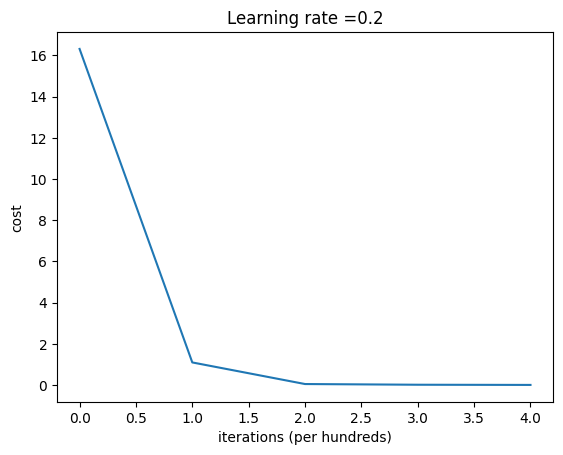

In [14]:
parameters = model(train_x, train_y, learning_rate=0.2, num_iterations=5000, initialization="he")

<a id="3"></a>
## 3.Weight Regularization

In [15]:
def compute_cost_with_regularization(A3, Y, parameters, lambd):
    """
    Implement the cost function with L2 regularization. See formula (2) above.
    
    Arguments:
    A3 -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    
    Returns:
    cost - value of the regularized loss function (formula (2))
    """
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y) # This gives you the cross-entropy part of the cost
    L2_regularization_cost = (lambd / (2 * m)) * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [16]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    """
    Implements the backward propagation of our baseline model to which we added an L2 regularization.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation()
    lambd -- regularization hyperparameter, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T) + ((lambd / m) * W3) ## regularization term ((lambd / m) * W3)
    db3 = 1. / m * np.sum(dZ3, axis=1, keepdims=True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T) + ((lambd / m) * W2) ## regularization term ((lambd / m) * W2)    
    db2 = 1. / m * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T) + ((lambd / m) * W1) ## ## regularization term ((lambd / m) * W1)
    db1 = 1. / m * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

<a id="4"></a>
## 4.Dropout

In [17]:
def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [18]:
def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    """
    Implements the forward propagation: LINEAR -> RELU + DROPOUT -> LINEAR -> RELU + DROPOUT -> LINEAR -> SIGMOID.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3":
                    W1 -- weight matrix of shape (20, 2)
                    b1 -- bias vector of shape (20, 1)
                    W2 -- weight matrix of shape (3, 20)
                    b2 -- bias vector of shape (3, 1)
                    W3 -- weight matrix of shape (1, 3)
                    b3 -- bias vector of shape (1, 1)
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    A3 -- last activation value, output of the forward propagation, of shape (1,1)
    cache -- tuple, information stored for computing the backward propagation
    """
    
    np.random.seed(1)
    
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)

    D1 = np.random.rand(A1.shape[0], A1.shape[1])
    D1 = (D1 < keep_prob).astype(int)
    A1 = np.multiply(D1, A1)
    A1 /= keep_prob
    
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)

    D2 = np.random.rand(A2.shape[0], A2.shape[1])
    D2 = (D2 < keep_prob).astype(int)
    A2 = np.multiply(D2, A2)
    A2 /= keep_prob
    
    
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

In [19]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    """
    Implements the backward propagation of our baseline model to which we added dropout.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation_with_dropout()
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims=True)
    dA2 = np.dot(W3.T, dZ3)

    dA2 *= D2
    dA2 /= keep_prob
        
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims=True)
    
    dA1 = np.dot(W2.T, dZ2)
    dA1 *= D1
    dA1 /= keep_prob
    
    
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims=True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

<a id="5"></a>
## 5.Training

In [28]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0, keep_prob = 1):
    """
    Implements a three-layer neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (output size, number of examples)
    learning_rate -- learning rate of the optimization
    num_iterations -- number of iterations of the optimization loop
    print_cost -- If True, print the cost every 10000 iterations
    lambd -- regularization hyperparameter, scalar
    keep_prob - probability of keeping a neuron active during drop-out, scalar.
    
    Returns:
    parameters -- parameters learned by the model. They can then be used to predict.
    """
        
    grads = {}
    costs = []                            # to keep track of the cost
    m = X.shape[1]                        # number of examples
    layers_dims = [X.shape[0], 64, 32, 1]
    
    # Initialize parameters dictionary.
    parameters = initialize_parameters_he(layers_dims)

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
        elif keep_prob < 1:
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Cost function
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
            
        # Backward propagation.
        assert (lambd == 0 or keep_prob == 1)   # it is possible to use both L2 regularization and dropout, 
                                                # but this assignment will only explore one at a time
        if lambd == 0 and keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Cost after iteration 0: 14.983986856553773
Cost after iteration 10000: 0.004381022946300421
Cost after iteration 20000: 0.0017154605841253904


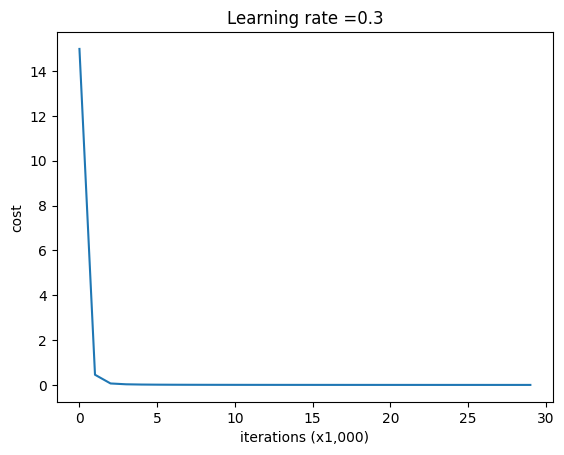

In [29]:
parameters = model(train_x, train_y, keep_prob = 0.86, learning_rate = 0.3)